Dev notebook
============

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage as ndi
from scipy import signal
from scipy import stats

import cv2

from domb.reg_type import wf_x2_m2 as WF
from domb.fret.e_fret.e_app import Eapp
from domb.red_green import wt_vs_mut  as WvM
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

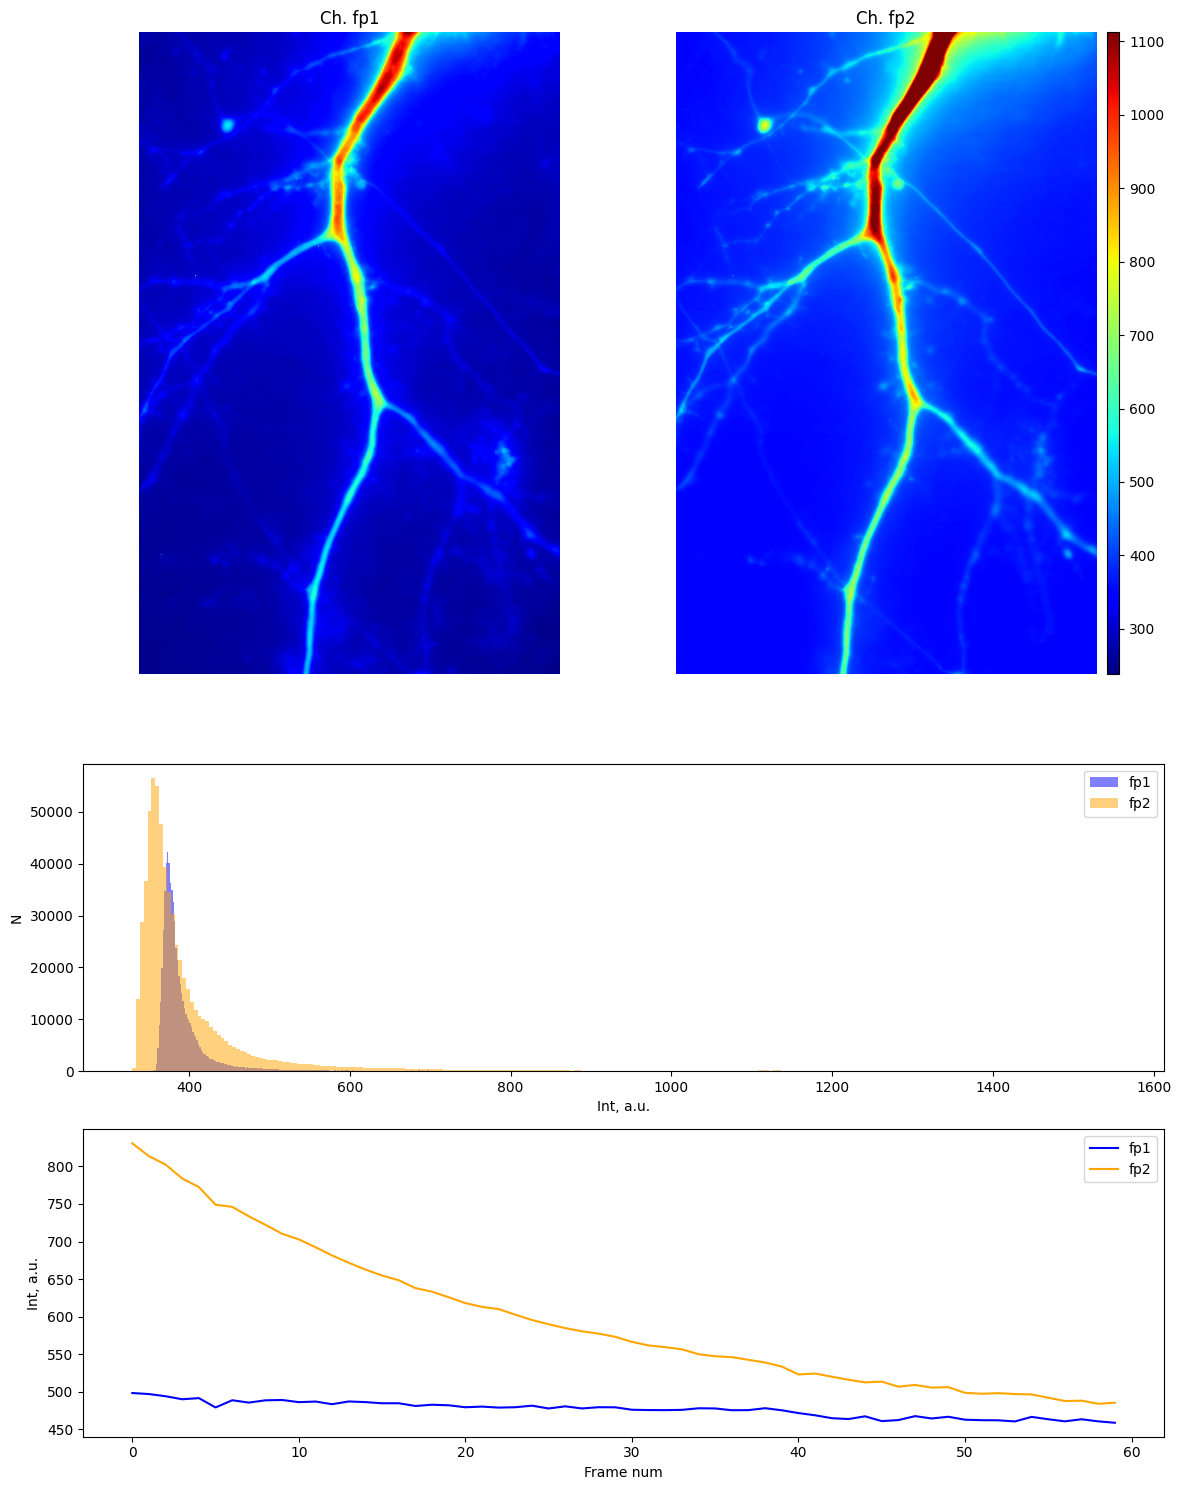

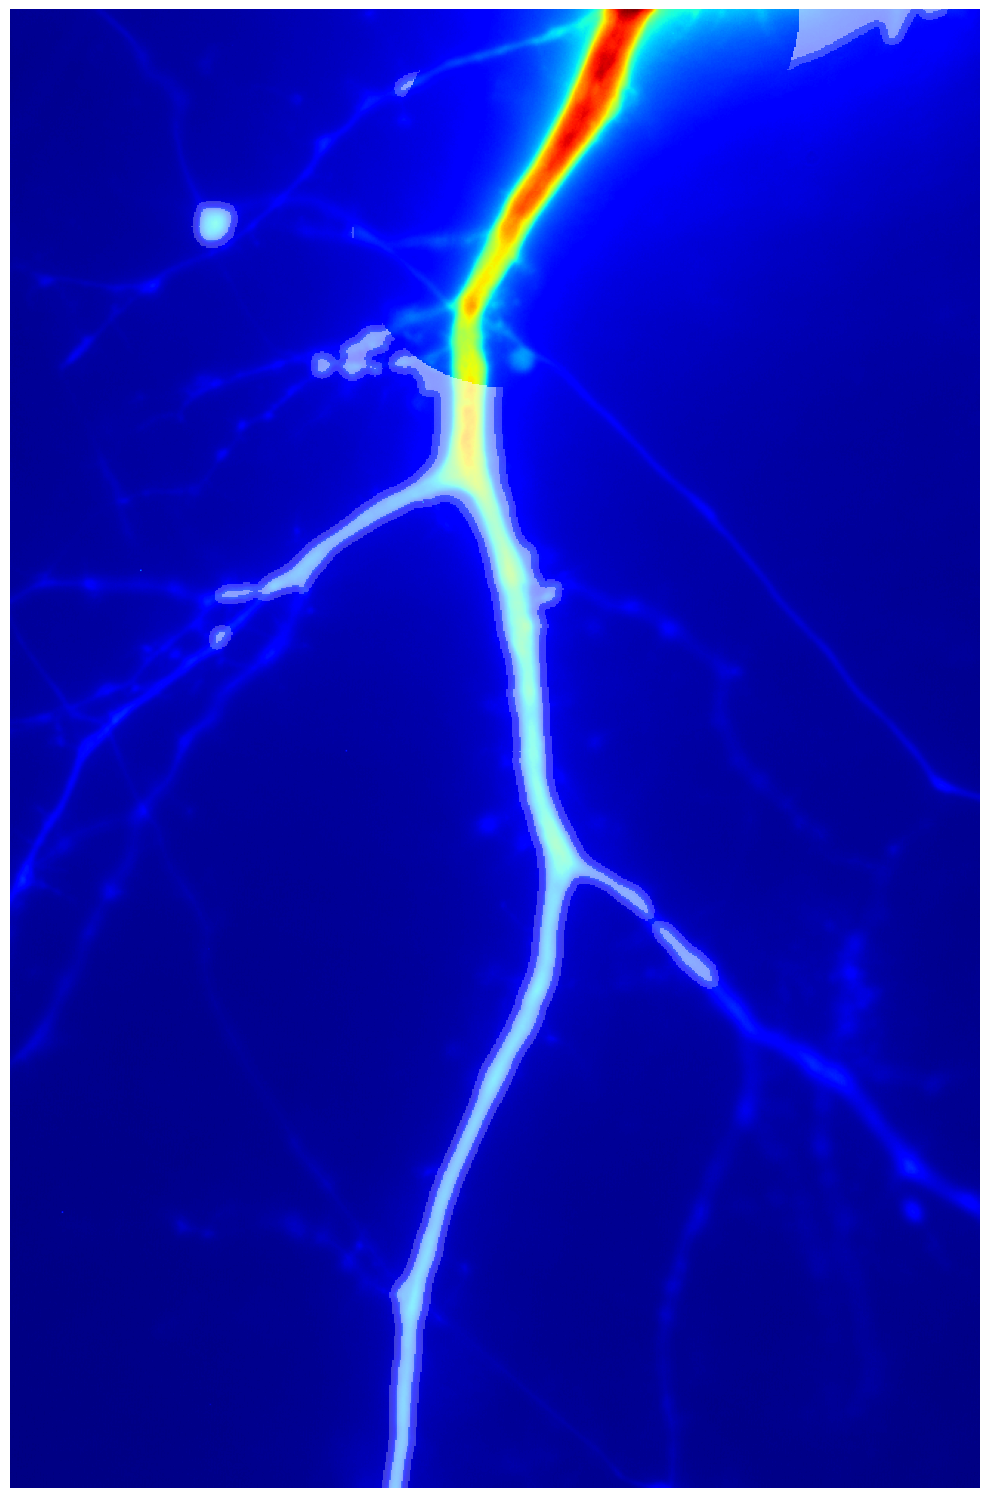

In [17]:
reg_path = 'data/wt_vs_mut/23_10_12_02.tif'
# reg_path = 'data/wt_vs_mut/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]


# fp1 - CFP, fp2 - YFP
reg = WF(img_path=reg_path, img_name=reg_name, ch_order={'fp1':1,'fp2':3}, wf_sigma=.75, border_crop=20,
         soma_mask=True, soma_th=.75, soma_ext=100, proc_sigma=1.5)  # processes masking parameters

reg.ch_pic()
reg.processes_mask_pic()

# Multiple stimulations

6
0


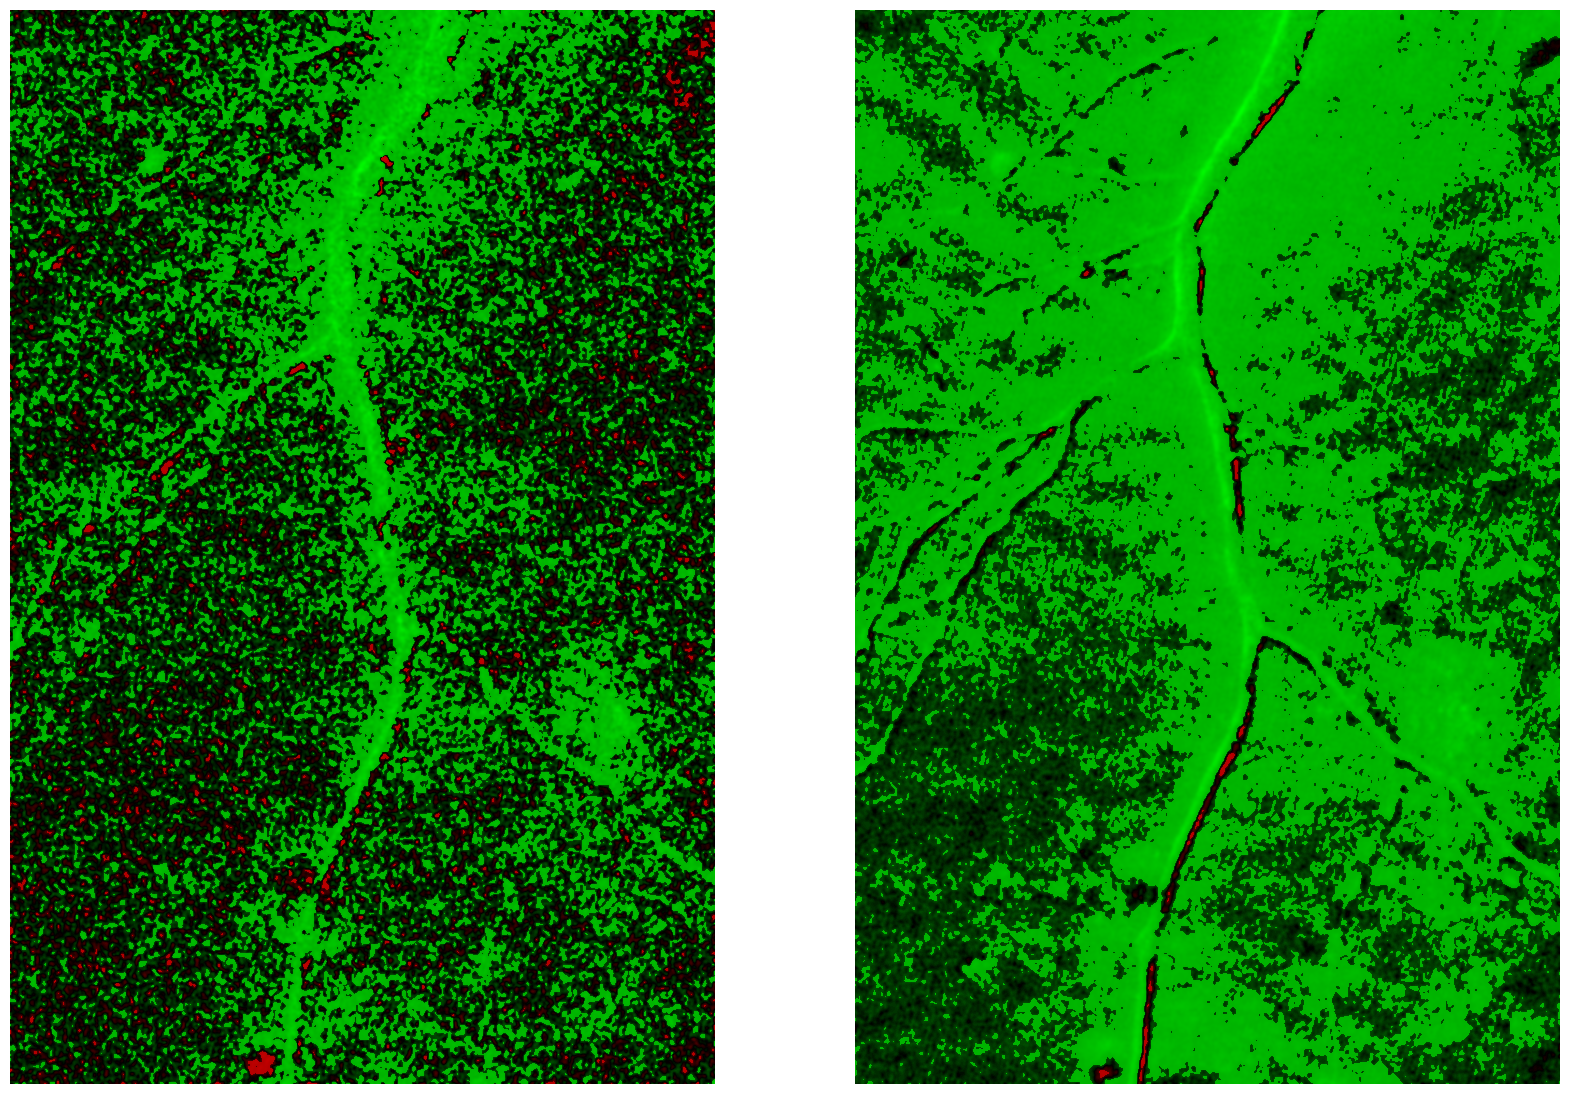

IndexError: tuple index out of range

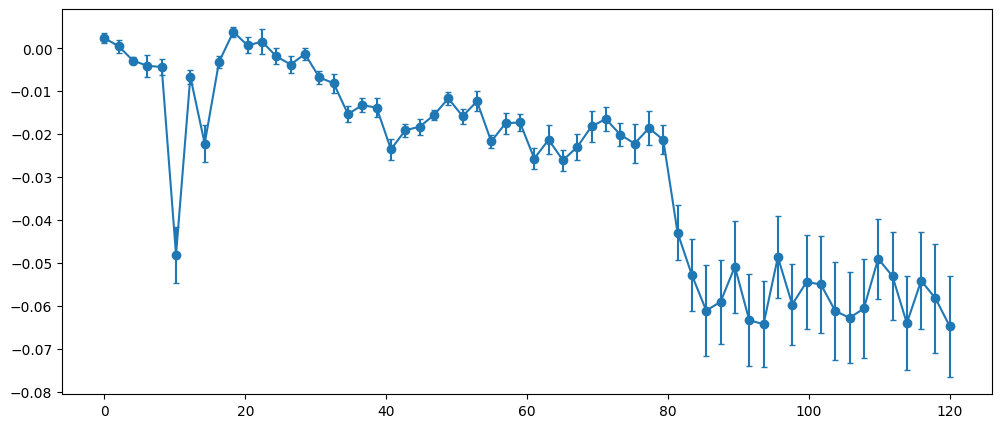

In [22]:
def up_mask_calc(input_img_series:np.ndarray, input_img_mask:np.ndarray,
                    sd_tolerance:int=2,
                    base_frames:int=5,
                    stim_list:list[int]=[10], stim_win:int=5):
    ref_img_series = filters.gaussian(input_img_series, sigma=1.25, channel_axis=0)

    img_base = np.mean(ref_img_series[:base_frames], axis=0)

    stim_dict = {}
    for stim_start in stim_list:
        img_max = np.mean(ref_img_series[stim_start:stim_start+stim_win+1], axis=0)

        img_diff = img_max - img_base
        img_diff = img_diff/np.max(np.abs(img_diff))

        diff_sd = np.std(ma.masked_where(~input_img_mask, img_diff))
        up_mask = img_diff > diff_sd * sd_tolerance

        up_mask_filt = morphology.opening(up_mask, footprint=morphology.disk(2))
        up_mask_filt = morphology.dilation(up_mask_filt, footprint=morphology.disk(1))
        up_label = measure.label(up_mask_filt)

        print(up_label.max())

        stim_dict.update({stim_start:{'img_max':img_max,
                                      'img_diff':img_diff,
                                      'up_mask':up_mask_filt,
                                      'up_label':up_label}})

    fig = plt.figure(figsize= (20, 20))
    for i in range(len(stim_list)):
        ax = fig.add_subplot(1, len(stim_list), i+1)
        ax.imshow(stim_dict[stim_list[i]]['img_diff'],
                  cmap=CMaps().cmap_red_green, vmin=-1, vmax=1)
        # ax.imshow(stim_dict[stim_list[i]]['up_label'])
        ax.axis('off')
    plt.show()

    return stim_dict

stim_dict = up_mask_calc(input_img_series=reg.fp1_img, input_img_mask=reg.proc_mask,
                         sd_tolerance=1.5,
                         base_frames=9,
                         stim_list=[9, 34], stim_win=3)


prof1_1, _ = masking.label_prof_arr(input_label=stim_dict[9]['up_label'], input_img_series=reg.fp1_img)
prof1_2, _ = masking.label_prof_arr(input_label=stim_dict[34]['up_label'], input_img_series=reg.fp1_img)

prof2_1, _ = masking.label_prof_arr(input_label=stim_dict[9]['up_label'], input_img_series=reg.fp2_img)
prof2_2, _ = masking.label_prof_arr(input_label=stim_dict[34]['up_label'], input_img_series=reg.fp2_img)

plot.stat_line_plot(arr_list=[prof1_1, prof1_2],
                    lab_list=['stim_1', 'stim_2'],
                    stat_method='ci',
                    stim_t=20,
                    figsize=(12,5))

plot.stat_line_plot(arr_list=[prof2_1, prof2_2],
                    lab_list=['stim_1', 'stim_2'],
                    stat_method='ci',
                    stim_t=20,
                    figsize=(12,5))


# Channels registration

## Skimage

In [ ]:
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from skimage import transform
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

In [ ]:
ref_img = reg.fp1_img[3]
offset_img = reg.fp2_img[3]
mask = reg.proc_mask

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=500)
print(shift, error, diffphase)

fig, ax = plt.subplots(ncols=2, figsize=(15,15))
ax[0].imshow(ref_img)
ax[1].imshow(offset_img)
ax[0].axis('off')
ax[1].axis('off')

#### Optical flow

In [ ]:
def flow_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    v, u = optical_flow_tvl1(ref_img, offset_img)
    nr, nc = ref_img.shape
    r_coord, c_coord = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    flow_warp_matrix = np.array([r_coord + v, c_coord + u])
    flow_warp_img = transform.warp(raw_offset_img, flow_warp_matrix, mode='edge', order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, flow_warp_img, upsample_factor=1000)
    print(f'Flow restoration: input shift={input_shift}, outputshift={output_shift}')
    return flow_warp_img

flow_warp_img = flow_restoration(ref_img, offset_img)

#### Phase corr

In [ ]:
def phase_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    tform = transform.SimilarityTransform(translation=(-input_shift[1], -input_shift[0]))
    phase_warp_img = transform.warp(raw_offset_img, tform, order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, phase_warp_img, upsample_factor=1000)
    print(f'Phase restoration: input shift={input_shift}, outputshift={output_shift}')
    return phase_warp_img

phase_warp_img = phase_restoration(ref_img, offset_img)

## OpenCV

In [ ]:
def Gradient(Image) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = filters.sobel_h(Image)
    grad_y = filters.sobel_v(Image)
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad.astype('float32')

Image1 = ref_img
Image2 = offset_img
algn_scale = 0.5
    
Temp1 = cv2.resize(Image1, dsize=(0, 0),
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)
Temp2 = cv2.resize(Image2, dsize=(0, 0), 
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)


print(Image1.shape)
print(Temp1.shape)

warp_mode = cv2.MOTION_AFFINE
WarpMatrix = np.eye(2, 3, dtype='float32')
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
(cc, WarpMatrix) = cv2.findTransformECC(Gradient(Temp1), Gradient(Temp2), WarpMatrix, warp_mode, criteria)
WarpMatrix[:, 2] = WarpMatrix[:, 2] / algn_scale

print(WarpMatrix)


In [ ]:
def cv_warp(Image2, WarpMatrix):
    warp_img = cv2.warpAffine(Image2, WarpMatrix, Image2.shape[::-1], flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)
    return warp_img
# warp_img_cv2 = transform.warp(offset_img, WarpMatrix, order=5)

ecc_warp_img = cv_warp(offset_img, WarpMatrix)

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
print(shift, error, diffphase)

shift, error, diffphase = phase_cross_correlation(ref_img, ecc_warp_img, upsample_factor=1000)
print(shift, error, diffphase)

## Algn comparison with flow

In [ ]:
def misalign_estimate(img1, img2):
    v, u = optical_flow_tvl1(img1, img2)
    norm = np.sqrt(u ** 2 + v ** 2)

    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = ref_img.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    print(phase_cross_correlation(img1, img2, upsample_factor=1000))

    plt.figure(figsize=(8, 8))
    plt.imshow(norm)
    plt.quiver(x, y, u_, v_, color='r', units='dots',
            angles='xy', scale_units='xy', lw=3)
    plt.show()

In [ ]:
misalign_estimate(ref_img, offset_img)

misalign_estimate(ref_img, flow_warp_img)

misalign_estimate(ref_img, phase_warp_img)

# misalign_estimate(ref_img, ecc_warp_img)

# FRET

In [ ]:
ch0_crop = np.array([reg.ch0_img[0], reg.ch0_img[-1]])
ch1_crop = np.array([reg.ch1_img[0], reg.ch1_img[-1]])
ch2_crop = np.array([reg.ch2_img[0], reg.ch2_img[-1]])
ch3_crop = np.array([reg.ch3_img[0], reg.ch3_img[-1]])

In [ ]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=ch0_crop,
                da_img=ch1_crop,
                ad_img=ch2_crop,
                aa_img=ch3_crop,
                abcd_list=abcd, G_val=G,
                mask=reg.narrow_proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

warp_FRET = Eapp(dd_img=ch0_crop,
                 da_img=ch1_crop,
                 ad_img=np.asarray([phase_restoration(raw_ref_img=ref_img, raw_offset_img=img) for img in ch2_crop]),
                 aa_img=np.asarray([phase_restoration(raw_ref_img=ref_img, raw_offset_img=img) for img in ch3_crop]),
                 abcd_list=abcd, G_val=G,
                 mask=reg.narrow_proc_mask, corr_by_mask=True)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
ax[0].imshow(reg_FRET.Ecorr_img[-1], cmap='jet')
ax[1].imshow(warp_FRET.Ecorr_img[-1], cmap='jet')
ax[0].axis('off')
ax[1].axis('off')